<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 03 — Classification

## 1) Ringkasan
Chapter ini membahas klasifikasi menggunakan dataset MNIST (digit tulisan tangan). Fokus utamanya:
- bedanya klasifikasi vs regresi
- evaluasi klasifikasi yang benar (confusion matrix, precision, recall, F1)
- mengatur threshold (trade-off precision vs recall)
- kurva PR dan ROC + AUC
- pengantar klasifikasi multiclass dan praktik evaluasi yang lebih realistis

## 2) Tujuan Pembelajaran
- Memahami masalah klasifikasi (binary vs multiclass) menggunakan MNIST.
- Mengerti kenapa accuracy bisa menipu pada dataset imbalanced.
- Menghitung dan menginterpretasi confusion matrix, precision, recall, dan F1.
- Memahami fungsi threshold pada decision score dan dampaknya ke precision/recall.
- Membuat dan membaca Precision–Recall curve serta ROC curve.


In [4]:
import numpy as np
from sklearn.datasets import fetch_openml

# Load MNIST dari OpenML
mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

# Split klasik MNIST: 60k train, 10k test
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# Shuffle train set (praktik umum sebelum CV)
rng = np.random.RandomState(42)
shuffle_idx = rng.permutation(60000)
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

# Target biner: apakah digit 5?
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

X_train.shape, X_test.shape, y_train_5[:10]


((60000, 784),
 (10000, 784),
 array([False, False, False, False, False, False, False, False,  True,
        False]))

## 3) Visualisasi Sampel Data

Tujuan: memastikan data benar berupa gambar 28×28 dan kita paham bentuk input yang dipakai model.


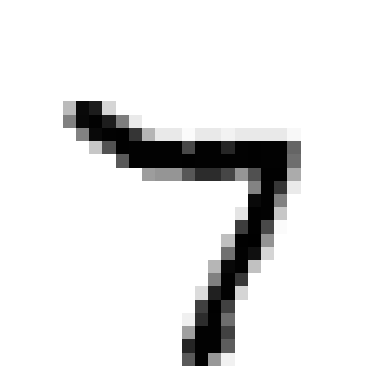

np.uint8(7)

In [5]:
import matplotlib.pyplot as plt

some_digit = X_train[0]
plt.imshow(some_digit.reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

y_train[0]


## 4) Baseline Classifier: SGD (Binary Classification)

Kita latih model klasifikasi biner “5 vs bukan 5” memakai `SGDClassifier`.

### Teori singkat: Accuracy pada data tidak seimbang (imbalanced)
Jika kelas “bukan 5” jauh lebih banyak, model yang selalu menebak “bukan 5” bisa tetap punya accuracy tinggi.
Karena itu kita butuh metrik lain: confusion matrix, precision, recall, dan F1.


In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

acc_scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
acc_scores, acc_scores.mean()


(array([0.9681 , 0.95655, 0.95515]), np.float64(0.9599333333333333))

## 5) Baseline Pembanding: DummyClassifier (Most Frequent)

`DummyClassifier(strategy="most_frequent")` selalu menebak kelas mayoritas.
Kalau akurasinya sudah tinggi, berarti accuracy saja belum cukup untuk menilai model.


In [7]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_scores = cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")
dummy_scores, dummy_scores.mean()


(array([0.90965, 0.90965, 0.90965]), np.float64(0.90965))

## 6) Confusion Matrix + Precision/Recall/F1

### Teori (inti evaluasi klasifikasi biner)
- TP: prediksi “5” dan benar “5”
- FP: prediksi “5” tapi sebenarnya bukan “5”
- FN: prediksi “bukan 5” tapi sebenarnya “5”
- TN: prediksi “bukan 5” dan benar

Rumus:
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)
- F1 = 2 * (precision * recall) / (precision + recall)

Kita gunakan `cross_val_predict` agar prediksi evaluasi berasal dari fold validasi (lebih fair).


In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cm = confusion_matrix(y_train_5, y_train_pred)
prec = precision_score(y_train_5, y_train_pred)
rec = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

cm, prec, rec, f1


(array([[53124,  1455],
        [  949,  4472]]),
 0.754513244474439,
 0.8249400479616307,
 0.7881565033486077)

## 7) Threshold: Mengatur Trade-off Precision vs Recall

Banyak classifier menghasilkan **decision score** (bukan probabilitas).
Default threshold biasanya 0 (score >= 0 → kelas positif).

- Naikkan threshold → precision cenderung naik, recall turun.
- Turunkan threshold → recall cenderung naik, precision turun.

Kita ambil decision score via `cross_val_predict(..., method="decision_function")`.


In [9]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# contoh threshold manual
threshold = 8000
y_pred_thresh = (y_scores >= threshold)

precision_score(y_train_5, y_pred_thresh), recall_score(y_train_5, y_pred_thresh)


(0.9633389734912577, 0.31507102010699134)

## 8) Precision–Recall Curve

PR curve cocok untuk dataset imbalanced karena fokus pada performa kelas positif.
Kita plot precision dan recall terhadap threshold.


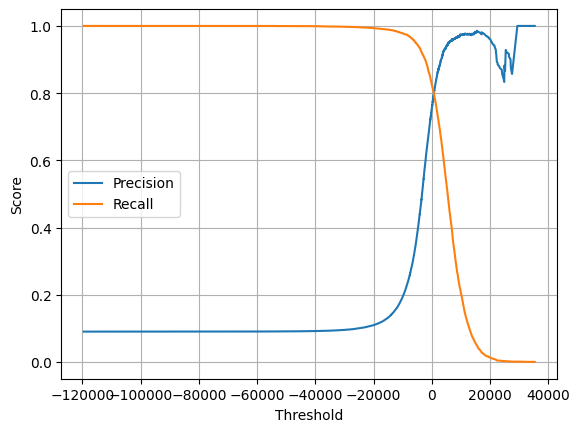

In [10]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


## 9) ROC Curve + AUC

ROC memplot:
- TPR (Recall) vs FPR

AUC adalah luas area di bawah kurva ROC.
ROC berguna, tetapi pada dataset sangat imbalanced, PR curve sering lebih informatif untuk kelas positif.


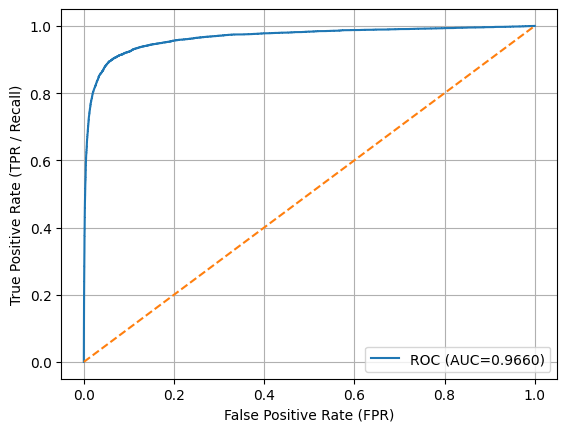

np.float64(0.9660259463088996)

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, roc_thresholds = roc_curve(y_train_5, y_scores)
auc = roc_auc_score(y_train_5, y_scores)

plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR / Recall)")
plt.legend()
plt.grid(True)
plt.show()

auc


## 10) Multiclass Classification (0–9) dengan SGD (One-vs-All)

Di scikit-learn, banyak classifier (termasuk `SGDClassifier`) mendukung multiclass dengan strategi **One-vs-All (OvA)**:
- Model melatih 10 classifier biner (tiap digit vs yang lain).
- Prediksi diambil dari kelas dengan score tertinggi (`decision_function`).

Catatan penting: untuk model berbasis gradien seperti SGD, **feature scaling** biasanya meningkatkan performa dan stabilitas training.


In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Train multiclass SGD (0-9)
sgd_clf_mc = SGDClassifier(random_state=42)
sgd_clf_mc.fit(X_train, y_train)

# Cek prediksi untuk contoh digit yang tadi
pred_digit = sgd_clf_mc.predict([some_digit])[0]
score_shape = sgd_clf_mc.decision_function([some_digit]).shape

pred_digit, score_shape


(np.uint8(7), (1, 10))

In [13]:
# Scaling (SGD umumnya lebih baik jika fitur diskalakan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))

mc_scores = cross_val_score(sgd_clf_mc, X_train_scaled, y_train, cv=3, scoring="accuracy")
mc_scores, mc_scores.mean()


(array([0.90685, 0.9049 , 0.89395]), np.float64(0.9019))

## 11) Confusion Matrix (Multiclass)

Confusion matrix multiclass merangkum prediksi untuk semua kelas (0–9):
- Baris = label asli
- Kolom = label prediksi
Diagonal utama menunjukkan prediksi benar.
Sel yang besar di luar diagonal menunjukkan pasangan kelas yang sering tertukar (mis. 5 vs 3).

Kita gunakan `cross_val_predict` agar prediksi confusion matrix berasal dari fold validasi (lebih fair).


In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Prediksi multiclass via CV (pakai data yang sudah discale)
y_train_pred_mc = cross_val_predict(sgd_clf_mc, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred_mc)
conf_mx.shape, conf_mx[:3, :3]


((10, 10),
 array([[5591,    0,   21],
        [   1, 6420,   44],
        [  27,   30, 5286]]))

## 12) Visualisasi Confusion Matrix (Raw & Normalized)

- **Raw confusion matrix** menunjukkan jumlah absolut salah/benar.
- **Normalized confusion matrix** (dibagi per baris) menunjukkan proporsi kesalahan untuk tiap kelas, sehingga lebih mudah melihat pola kesalahan meski jumlah sampel per kelas berbeda.


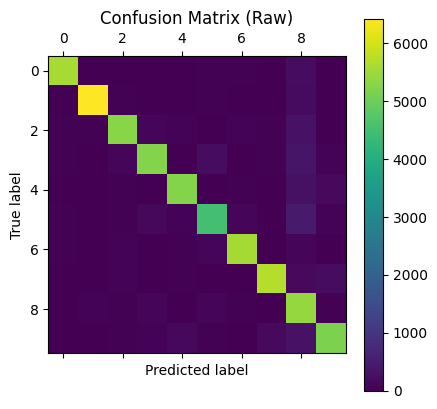

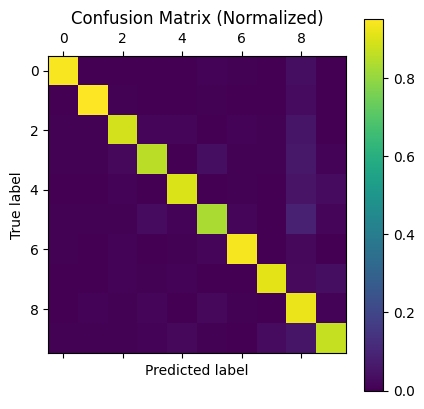

In [15]:
import matplotlib.pyplot as plt

# Raw confusion matrix
plt.matshow(conf_mx)
plt.title("Confusion Matrix (Raw)")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Normalized (per baris)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

plt.matshow(norm_conf_mx)
plt.title("Confusion Matrix (Normalized)")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


## 13) Error Analysis: Fokus pada Kesalahan (Tanpa Diagonal)

Agar pola kesalahan lebih terlihat, kita set diagonal confusion matrix bernilai 0 (menghilangkan prediksi benar).
Lalu kita plot ulang versi normalized untuk melihat pasangan digit yang paling sering tertukar.


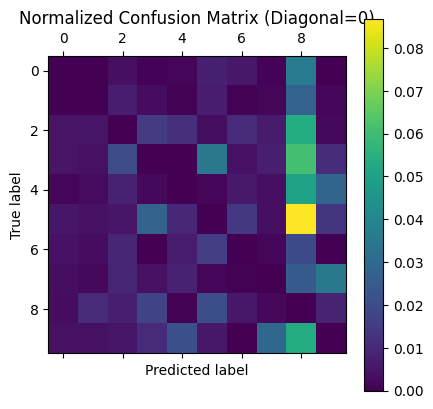

In [16]:
# Copy normalized matrix lalu hilangkan diagonal
norm_conf_mx_no_diag = norm_conf_mx.copy()
np.fill_diagonal(norm_conf_mx_no_diag, 0)

plt.matshow(norm_conf_mx_no_diag)
plt.title("Normalized Confusion Matrix (Diagonal=0)")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


## 14) Contoh Kesalahan Prediksi (Visual Inspection)

Kita ambil beberapa contoh gambar yang sering salah (true=a, pred=b) untuk melihat penyebabnya (bentuk mirip, tulisan tipis, noise, dsb).


Count true=5 predicted=8: 471


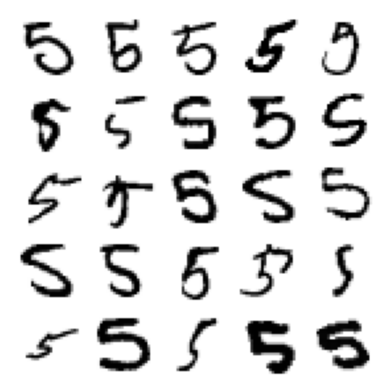

Count true=3 predicted=8: 374


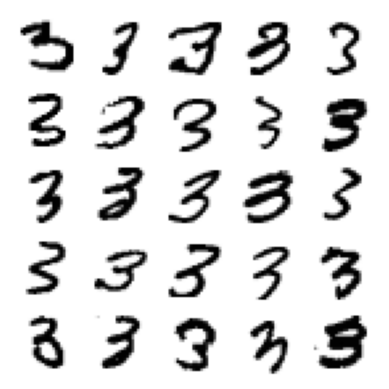

In [17]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    for row in range(n_rows):
        rimages = images[row*images_per_row:(row+1)*images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap="binary", **options)
    plt.axis("off")

def show_misclassified(true_label, pred_label, n=25):
    mask = (y_train == true_label) & (y_train_pred_mc == pred_label)
    X_err = X_train[mask]
    print(f"Count true={true_label} predicted={pred_label}: {X_err.shape[0]}")
    if X_err.shape[0] == 0:
        return
    plot_digits(X_err[:n], images_per_row=5)
    plt.show()

# Ganti pasangan ini sesuai “kotak paling terang” di plot kamu
show_misclassified(true_label=5, pred_label=8, n=25)
show_misclassified(true_label=3, pred_label=8, n=25)


**Insight singkat:**
- Banyak “5” yang tertukar jadi “8” karena goresannya tebal/tertutup sehingga bentuknya mirip (loop terlihat seperti 8).
- Banyak “3” yang tertukar jadi “8” karena bentuk “3” yang sangat melengkung/tertutup membuatnya terlihat seperti dua loop.
- Ini menunjukkan model linear (SGD) sensitif pada variasi tulisan; model non-linear (mis. SVM/RBF atau CNN) biasanya lebih kuat untuk pola gambar.


## 15) Takeaways
- Untuk klasifikasi imbalanced, accuracy saja tidak cukup → gunakan confusion matrix, precision, recall, F1.
- Threshold mengontrol trade-off precision vs recall; PR curve sering lebih informatif daripada ROC pada kasus imbalanced.
- Untuk multiclass MNIST, scaling membantu SGD.
- Error analysis (lihat pasangan kelas yang sering tertukar + contoh gambar) memberi arah perbaikan model/fitur.

## 16) Referensi
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 3.
- Scikit-learn Documentation: `SGDClassifier`, `cross_val_predict`, `confusion_matrix`, `precision_recall_curve`, `roc_curve`.
